In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# === Paramètres ===
BATCH_SIZE = 128
NOISE_DIM = 64
EPOCHS = 200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LR = 2e-4
SAVE_INTERVAL = 10



# === Dossiers ===
base_model_dir = "/content/drive/MyDrive/hunt_right"  # Poids préentraînés
fine_tune_model_dir = "/content/drive/MyDrive/hunt_right/saved_models_hunt_right"
sample_dir = "/content/drive/MyDrive/hunt_right/generated_samples_hunt_right"
data_path = "/content/drive/MyDrive/hunt_right/hunt_all_right.npz"

os.makedirs(fine_tune_model_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

# === Construction du générateur et du critic ===
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),

        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

def build_critic():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1200, 1)),

        tf.keras.layers.Conv1D(64, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(128, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(256, 15, strides=3, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model

# === Initialisation ===
generator = build_generator()
critic = build_critic()

generator_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
critic_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)

# === Charger les poids préentraînés sur "hunt" ===
generator.load_weights(f"{base_model_dir}/generator_epoch_250.weights.h5")
critic.load_weights(f"{base_model_dir}/critic_epoch_250.weights.h5")
print("✓ Poids préentraînés chargés depuis les sujets contrôles")

# === Chargement des données hunt right ===
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
data = data.astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

# === Gradient Penalty ===
def gradient_penalty(real, fake):
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0., 1.)
    interpolated = real + alpha * (fake - real)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = critic(interpolated, training=True)

    grads = tape.gradient(pred, [interpolated])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    return tf.reduce_mean((slopes - 1.)**2)

# === Entraînement ===
fixed_noise = tf.random.normal([5, NOISE_DIM])
history = {'critic': [], 'gen': []}

def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # Critic
    for _ in range(CRITIC_STEPS):
        with tf.GradientTape() as tape:
            fake = generator(noise, training=True)
            real_out = critic(batch, training=True)
            fake_out = critic(fake, training=True)

            gp = gradient_penalty(batch, fake)
            c_loss = tf.reduce_mean(fake_out) - tf.reduce_mean(real_out) + GP_WEIGHT * gp

        grads = tape.gradient(c_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

    # Generator
    with tf.GradientTape() as tape:
        fake = generator(noise, training=True)
        g_loss = -tf.reduce_mean(critic(fake, training=True))

    grads = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return c_loss, g_loss

# === Boucle d'entraînement ===
for epoch in range(EPOCHS):
    epoch_c_loss = []
    epoch_g_loss = []

    for batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        c_loss, g_loss = train_step(batch)
        epoch_c_loss.append(c_loss)
        epoch_g_loss.append(g_loss)

    avg_c_loss = tf.reduce_mean(epoch_c_loss)
    avg_g_loss = tf.reduce_mean(epoch_g_loss)

    history['critic'].append(avg_c_loss.numpy())
    history['gen'].append(avg_g_loss.numpy())

    print(f"\nEpoch {epoch+1} | Critic: {avg_c_loss:.4f} | Generator: {avg_g_loss:.4f}")

    # Sauvegarde périodique
    if (epoch + 1) % SAVE_INTERVAL == 0:
        generator.save_weights(f'{fine_tune_model_dir}/generator_epoch_{epoch+1}.weights.h5')
        critic.save_weights(f'{fine_tune_model_dir}/critic_epoch_{epoch+1}.weights.h5')

        samples = generator(fixed_noise)
        plt.figure(figsize=(15, 3))
        for i in range(5):
            plt.subplot(5, 1, i+1)
            plt.plot(samples[i, :, 0])
            plt.ylim(-1, 1)
        plt.tight_layout()
        plt.savefig(f'{sample_dir}/epoch_{epoch+1}.png')
        plt.close()

print("✓ Fine-tuning terminé pour hunt pied droite")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


✓ Poids préentraînés chargés depuis les sujets contrôles


Epoch 1/200: 100%|██████████| 21/21 [00:19<00:00,  1.09it/s]



Epoch 1 | Critic: -2.2576 | Generator: -21.1825


Epoch 2/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 2 | Critic: -3.4665 | Generator: 5.4445


Epoch 3/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 3 | Critic: -3.3592 | Generator: 21.1445


Epoch 4/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 4 | Critic: -2.1637 | Generator: 15.5933


Epoch 5/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 5 | Critic: -1.7276 | Generator: 28.9697


Epoch 6/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 6 | Critic: -1.3080 | Generator: 15.5972


Epoch 7/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 7 | Critic: -1.5563 | Generator: 16.4531


Epoch 8/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 8 | Critic: -1.5469 | Generator: -0.6900


Epoch 9/200: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]



Epoch 9 | Critic: -0.9536 | Generator: -4.4860


Epoch 10/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 10 | Critic: -1.1080 | Generator: 10.0688


Epoch 11/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 11 | Critic: -0.7113 | Generator: 9.1650


Epoch 12/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 12 | Critic: -1.1400 | Generator: 30.1515


Epoch 13/200: 100%|██████████| 21/21 [00:15<00:00,  1.31it/s]



Epoch 13 | Critic: -1.1950 | Generator: 6.1209


Epoch 14/200: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]



Epoch 14 | Critic: -0.8640 | Generator: 24.4397


Epoch 15/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 15 | Critic: -0.9736 | Generator: -0.2475


Epoch 16/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 16 | Critic: -1.0165 | Generator: -19.8066


Epoch 17/200: 100%|██████████| 21/21 [00:16<00:00,  1.26it/s]



Epoch 17 | Critic: -1.4557 | Generator: 42.1126


Epoch 18/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 18 | Critic: -0.9960 | Generator: 18.2021


Epoch 19/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 19 | Critic: -1.5061 | Generator: -32.1686


Epoch 20/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 20 | Critic: -1.1181 | Generator: 17.0987


Epoch 21/200: 100%|██████████| 21/21 [00:16<00:00,  1.27it/s]



Epoch 21 | Critic: -1.2714 | Generator: 43.1633


Epoch 22/200: 100%|██████████| 21/21 [00:15<00:00,  1.34it/s]



Epoch 22 | Critic: -1.1733 | Generator: 13.1143


Epoch 23/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 23 | Critic: -1.3332 | Generator: -32.8764


Epoch 24/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 24 | Critic: -1.0562 | Generator: 13.0851


Epoch 25/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 25 | Critic: -1.1521 | Generator: -25.6909


Epoch 26/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 26 | Critic: -1.1430 | Generator: 29.5159


Epoch 27/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 27 | Critic: -1.0819 | Generator: -10.3689


Epoch 28/200: 100%|██████████| 21/21 [00:15<00:00,  1.34it/s]



Epoch 28 | Critic: -0.9254 | Generator: -26.4257


Epoch 29/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 29 | Critic: -1.3030 | Generator: -16.3654


Epoch 30/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 30 | Critic: -1.3391 | Generator: -17.8513


Epoch 31/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 31 | Critic: -1.2026 | Generator: -35.5841


Epoch 32/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 32 | Critic: -1.0121 | Generator: -26.8492


Epoch 33/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 33 | Critic: -1.2154 | Generator: -24.4407


Epoch 34/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 34 | Critic: -1.3601 | Generator: -11.4095


Epoch 35/200: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]



Epoch 35 | Critic: -1.0309 | Generator: 35.0007


Epoch 36/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 36 | Critic: -0.9610 | Generator: -2.4899


Epoch 37/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 37 | Critic: -0.7692 | Generator: -12.4773


Epoch 38/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 38 | Critic: -0.8507 | Generator: 8.0390


Epoch 39/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 39 | Critic: -0.8175 | Generator: -31.3818


Epoch 40/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 40 | Critic: -1.0016 | Generator: 13.2045


Epoch 41/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 41 | Critic: -1.1523 | Generator: -21.5643


Epoch 42/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 42 | Critic: -0.9296 | Generator: 34.2990


Epoch 43/200: 100%|██████████| 21/21 [00:15<00:00,  1.33it/s]



Epoch 43 | Critic: -1.1257 | Generator: 10.5891


Epoch 44/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 44 | Critic: -1.0457 | Generator: -6.3463


Epoch 45/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 45 | Critic: -1.2092 | Generator: 17.6999


Epoch 46/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 46 | Critic: -1.2678 | Generator: -34.3188


Epoch 47/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 47 | Critic: -1.2676 | Generator: 27.6278


Epoch 48/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 48 | Critic: -1.4061 | Generator: -10.7250


Epoch 49/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 49 | Critic: -1.3525 | Generator: 13.1197


Epoch 50/200: 100%|██████████| 21/21 [00:15<00:00,  1.40it/s]



Epoch 50 | Critic: -1.3940 | Generator: 12.3613


Epoch 51/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 51 | Critic: -1.1692 | Generator: -31.7729


Epoch 52/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 52 | Critic: -0.9852 | Generator: 24.3096


Epoch 53/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 53 | Critic: -0.7866 | Generator: -30.0360


Epoch 54/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 54 | Critic: -0.7714 | Generator: 8.0626


Epoch 55/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 55 | Critic: -0.4256 | Generator: 9.2837


Epoch 56/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 56 | Critic: -0.1467 | Generator: 3.2126


Epoch 57/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 57 | Critic: -0.6839 | Generator: 9.9715


Epoch 58/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 58 | Critic: -0.6261 | Generator: -15.8812


Epoch 59/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 59 | Critic: -0.7174 | Generator: 22.2057


Epoch 60/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 60 | Critic: -0.8342 | Generator: -21.2963


Epoch 61/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 61 | Critic: -0.7617 | Generator: 30.2587


Epoch 62/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 62 | Critic: -0.9497 | Generator: -3.1463


Epoch 63/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 63 | Critic: -1.1607 | Generator: 12.4652


Epoch 64/200: 100%|██████████| 21/21 [00:15<00:00,  1.40it/s]



Epoch 64 | Critic: -1.2089 | Generator: 24.8745


Epoch 65/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 65 | Critic: -0.8517 | Generator: 25.4315


Epoch 66/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 66 | Critic: -1.3282 | Generator: -21.9439


Epoch 67/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 67 | Critic: -1.2184 | Generator: 29.0184


Epoch 68/200: 100%|██████████| 21/21 [00:15<00:00,  1.40it/s]



Epoch 68 | Critic: -1.0409 | Generator: 37.8589


Epoch 69/200: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]



Epoch 69 | Critic: -1.1758 | Generator: -38.9099


Epoch 70/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 70 | Critic: -0.9225 | Generator: 24.5602


Epoch 71/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 71 | Critic: -1.2137 | Generator: 7.8862


Epoch 72/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 72 | Critic: -1.4049 | Generator: -33.4474


Epoch 73/200: 100%|██████████| 21/21 [00:15<00:00,  1.40it/s]



Epoch 73 | Critic: -1.0926 | Generator: 51.5641


Epoch 74/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 74 | Critic: -1.0123 | Generator: -25.8528


Epoch 75/200: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]



Epoch 75 | Critic: -1.1365 | Generator: 43.4900


Epoch 76/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 76 | Critic: -0.9944 | Generator: 46.6621


Epoch 77/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 77 | Critic: -0.7687 | Generator: 39.6849


Epoch 78/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 78 | Critic: -0.6362 | Generator: -6.9191


Epoch 79/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 79 | Critic: -0.5889 | Generator: -1.3690


Epoch 80/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 80 | Critic: -0.7657 | Generator: 14.3370


Epoch 81/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 81 | Critic: -0.6794 | Generator: -4.8791


Epoch 82/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 82 | Critic: -0.5381 | Generator: -16.4507


Epoch 83/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 83 | Critic: -0.6765 | Generator: -0.8838


Epoch 84/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 84 | Critic: -0.4859 | Generator: -28.1997


Epoch 85/200: 100%|██████████| 21/21 [00:15<00:00,  1.40it/s]



Epoch 85 | Critic: -0.9622 | Generator: 15.9274


Epoch 86/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 86 | Critic: -0.4497 | Generator: 17.0865


Epoch 87/200: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]



Epoch 87 | Critic: -0.6080 | Generator: 8.1197


Epoch 88/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 88 | Critic: -0.5610 | Generator: -6.2502


Epoch 89/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 89 | Critic: -0.6337 | Generator: -28.6258


Epoch 90/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 90 | Critic: -0.3846 | Generator: 22.3218


Epoch 91/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 91 | Critic: -0.4507 | Generator: -4.5197


Epoch 92/200: 100%|██████████| 21/21 [00:15<00:00,  1.40it/s]



Epoch 92 | Critic: -0.5495 | Generator: 36.1256


Epoch 93/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 93 | Critic: -0.2414 | Generator: 29.3071


Epoch 94/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 94 | Critic: -0.4757 | Generator: -4.4735


Epoch 95/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 95 | Critic: -0.3791 | Generator: -3.6654


Epoch 96/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 96 | Critic: -0.4691 | Generator: -3.7241


Epoch 97/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 97 | Critic: -0.9534 | Generator: 11.6770


Epoch 98/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 98 | Critic: -1.2944 | Generator: -20.4741


Epoch 99/200: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]



Epoch 99 | Critic: -1.2072 | Generator: 57.9993


Epoch 100/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 100 | Critic: -0.4210 | Generator: 39.6130


Epoch 101/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 101 | Critic: -0.4355 | Generator: 13.4856


Epoch 102/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 102 | Critic: -0.5597 | Generator: 25.4688


Epoch 103/200: 100%|██████████| 21/21 [00:15<00:00,  1.40it/s]



Epoch 103 | Critic: -0.4113 | Generator: 16.8321


Epoch 104/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 104 | Critic: -0.3677 | Generator: -15.4873


Epoch 105/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 105 | Critic: -0.3947 | Generator: -13.1162


Epoch 106/200: 100%|██████████| 21/21 [00:15<00:00,  1.35it/s]



Epoch 106 | Critic: -0.2113 | Generator: 10.5456


Epoch 107/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 107 | Critic: -0.0902 | Generator: 17.6710


Epoch 108/200: 100%|██████████| 21/21 [00:14<00:00,  1.42it/s]



Epoch 108 | Critic: -0.2870 | Generator: 16.7139


Epoch 109/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 109 | Critic: 0.0652 | Generator: 5.8191


Epoch 110/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 110 | Critic: -0.3689 | Generator: 0.8243


Epoch 111/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 111 | Critic: -0.9966 | Generator: -3.6773


Epoch 112/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 112 | Critic: -0.6290 | Generator: -13.8312


Epoch 113/200: 100%|██████████| 21/21 [00:15<00:00,  1.40it/s]



Epoch 113 | Critic: -0.8127 | Generator: -12.9751


Epoch 114/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 114 | Critic: -0.6552 | Generator: 14.7510


Epoch 115/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 115 | Critic: -0.6023 | Generator: -36.8572


Epoch 116/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 116 | Critic: -0.4648 | Generator: -6.2727


Epoch 117/200: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]



Epoch 117 | Critic: -0.6331 | Generator: 31.5562


Epoch 118/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 118 | Critic: -0.3516 | Generator: 27.6593


Epoch 119/200: 100%|██████████| 21/21 [00:15<00:00,  1.40it/s]



Epoch 119 | Critic: -0.4460 | Generator: 16.6024


Epoch 120/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 120 | Critic: -0.2667 | Generator: -9.6850


Epoch 121/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 121 | Critic: -0.4937 | Generator: -18.2853


Epoch 122/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 122 | Critic: -0.4550 | Generator: 21.9819


Epoch 123/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 123 | Critic: -0.3193 | Generator: -2.8944


Epoch 124/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 124 | Critic: -0.2836 | Generator: -17.1198


Epoch 125/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 125 | Critic: -0.4168 | Generator: -26.1213


Epoch 126/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 126 | Critic: -0.3260 | Generator: 18.2537


Epoch 127/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 127 | Critic: -0.3986 | Generator: -2.4815


Epoch 128/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 128 | Critic: -0.0858 | Generator: -1.2171


Epoch 129/200: 100%|██████████| 21/21 [00:14<00:00,  1.43it/s]



Epoch 129 | Critic: -0.5619 | Generator: 4.8383


Epoch 130/200: 100%|██████████| 21/21 [00:14<00:00,  1.42it/s]



Epoch 130 | Critic: -0.6911 | Generator: -16.1076


Epoch 131/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 131 | Critic: -0.6851 | Generator: -12.9118


Epoch 132/200: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]



Epoch 132 | Critic: -0.7829 | Generator: -12.9469


Epoch 133/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 133 | Critic: -0.6159 | Generator: -45.5252


Epoch 134/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 134 | Critic: -0.9672 | Generator: -46.3811


Epoch 135/200: 100%|██████████| 21/21 [00:15<00:00,  1.40it/s]



Epoch 135 | Critic: -0.5116 | Generator: -35.0436


Epoch 136/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 136 | Critic: -0.6496 | Generator: -45.5896


Epoch 137/200: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]



Epoch 137 | Critic: -0.6383 | Generator: -17.6622


Epoch 138/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 138 | Critic: -0.4478 | Generator: 7.5582


Epoch 139/200: 100%|██████████| 21/21 [00:14<00:00,  1.43it/s]



Epoch 139 | Critic: -0.7539 | Generator: 13.5672


Epoch 140/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 140 | Critic: -0.7735 | Generator: 35.4368


Epoch 141/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 141 | Critic: -0.4252 | Generator: 45.8886


Epoch 142/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 142 | Critic: -0.4716 | Generator: -3.6577


Epoch 143/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 143 | Critic: -0.7201 | Generator: -4.4378


Epoch 144/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 144 | Critic: -0.3665 | Generator: -23.1722


Epoch 145/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 145 | Critic: -0.4365 | Generator: -44.2355


Epoch 146/200: 100%|██████████| 21/21 [00:15<00:00,  1.40it/s]



Epoch 146 | Critic: -0.4780 | Generator: -40.5319


Epoch 147/200: 100%|██████████| 21/21 [00:14<00:00,  1.42it/s]



Epoch 147 | Critic: -0.5729 | Generator: -2.3038


Epoch 148/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 148 | Critic: -0.0871 | Generator: 35.8653


Epoch 149/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 149 | Critic: 0.0119 | Generator: -3.6616


Epoch 150/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 150 | Critic: -0.6593 | Generator: 20.8085


Epoch 151/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 151 | Critic: -0.5421 | Generator: -41.3911


Epoch 152/200: 100%|██████████| 21/21 [00:15<00:00,  1.37it/s]



Epoch 152 | Critic: -0.5069 | Generator: -34.2233


Epoch 153/200: 100%|██████████| 21/21 [00:15<00:00,  1.39it/s]



Epoch 153 | Critic: -0.4224 | Generator: -51.3599


Epoch 154/200: 100%|██████████| 21/21 [00:14<00:00,  1.42it/s]



Epoch 154 | Critic: -0.2933 | Generator: -47.4398


Epoch 155/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 155 | Critic: -0.1677 | Generator: -23.0998


Epoch 156/200: 100%|██████████| 21/21 [00:15<00:00,  1.34it/s]



Epoch 156 | Critic: 0.0071 | Generator: -9.0593


Epoch 157/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 157 | Critic: -0.1635 | Generator: 27.2663


Epoch 158/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 158 | Critic: -0.2241 | Generator: -4.1949


Epoch 159/200: 100%|██████████| 21/21 [00:15<00:00,  1.36it/s]



Epoch 159 | Critic: -0.4447 | Generator: -55.4478


Epoch 160/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 160 | Critic: -0.5746 | Generator: -59.1781


Epoch 161/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 161 | Critic: -0.4925 | Generator: -59.7130


Epoch 162/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 162 | Critic: -0.3830 | Generator: -38.1098


Epoch 163/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 163 | Critic: -0.0654 | Generator: -22.9719


Epoch 164/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 164 | Critic: -0.3309 | Generator: -18.9882


Epoch 165/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 165 | Critic: -0.5971 | Generator: -14.9768


Epoch 166/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 166 | Critic: -0.6643 | Generator: 50.4249


Epoch 167/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 167 | Critic: -0.0187 | Generator: 17.2774


Epoch 168/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 168 | Critic: -0.1339 | Generator: -12.1589


Epoch 169/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 169 | Critic: -0.4968 | Generator: 22.2709


Epoch 170/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 170 | Critic: -0.4233 | Generator: 11.4650


Epoch 171/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 171 | Critic: -0.8795 | Generator: 6.7483


Epoch 172/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 172 | Critic: 0.0689 | Generator: 32.8126


Epoch 173/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 173 | Critic: 0.0144 | Generator: 47.1029


Epoch 174/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 174 | Critic: -0.5083 | Generator: 26.1902


Epoch 175/200: 100%|██████████| 21/21 [00:14<00:00,  1.42it/s]



Epoch 175 | Critic: -0.5295 | Generator: 30.7641


Epoch 176/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 176 | Critic: -0.8808 | Generator: 24.1703


Epoch 177/200: 100%|██████████| 21/21 [00:14<00:00,  1.43it/s]



Epoch 177 | Critic: -0.7643 | Generator: 4.1091


Epoch 178/200: 100%|██████████| 21/21 [00:14<00:00,  1.42it/s]



Epoch 178 | Critic: -0.5675 | Generator: 62.4479


Epoch 179/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 179 | Critic: -1.1366 | Generator: 52.1241


Epoch 180/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 180 | Critic: -0.4101 | Generator: 61.8635


Epoch 181/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 181 | Critic: -0.4339 | Generator: 35.9378


Epoch 182/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 182 | Critic: -0.1785 | Generator: 29.1278


Epoch 183/200: 100%|██████████| 21/21 [00:14<00:00,  1.42it/s]



Epoch 183 | Critic: -0.0737 | Generator: 16.5779


Epoch 184/200: 100%|██████████| 21/21 [00:14<00:00,  1.43it/s]



Epoch 184 | Critic: -0.3273 | Generator: 13.4518


Epoch 185/200: 100%|██████████| 21/21 [00:14<00:00,  1.42it/s]



Epoch 185 | Critic: -0.4539 | Generator: 8.7342


Epoch 186/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 186 | Critic: -0.0612 | Generator: 23.8215


Epoch 187/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 187 | Critic: -0.8213 | Generator: 23.2138


Epoch 188/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 188 | Critic: -0.3722 | Generator: -8.8934


Epoch 189/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 189 | Critic: -0.4021 | Generator: 26.6484


Epoch 190/200: 100%|██████████| 21/21 [00:14<00:00,  1.40it/s]



Epoch 190 | Critic: -0.1479 | Generator: 10.6238


Epoch 191/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 191 | Critic: -0.1244 | Generator: 29.0251


Epoch 192/200: 100%|██████████| 21/21 [00:14<00:00,  1.41it/s]



Epoch 192 | Critic: -0.2867 | Generator: 18.2966


Epoch 193/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 193 | Critic: 0.0835 | Generator: 4.5689


Epoch 194/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 194 | Critic: -0.4176 | Generator: 8.3701


Epoch 195/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 195 | Critic: -0.6215 | Generator: 21.8854


Epoch 196/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 196 | Critic: 0.2745 | Generator: 1.4733


Epoch 197/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 197 | Critic: 0.0642 | Generator: -1.4101


Epoch 198/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 198 | Critic: -0.5320 | Generator: -30.3084


Epoch 199/200: 100%|██████████| 21/21 [00:14<00:00,  1.43it/s]



Epoch 199 | Critic: -0.1686 | Generator: -11.8343


Epoch 200/200: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]



Epoch 200 | Critic: -0.1714 | Generator: -21.3658
✓ Fine-tuning terminé pour hunt pied droite


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')  # Suppress general warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING messages

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


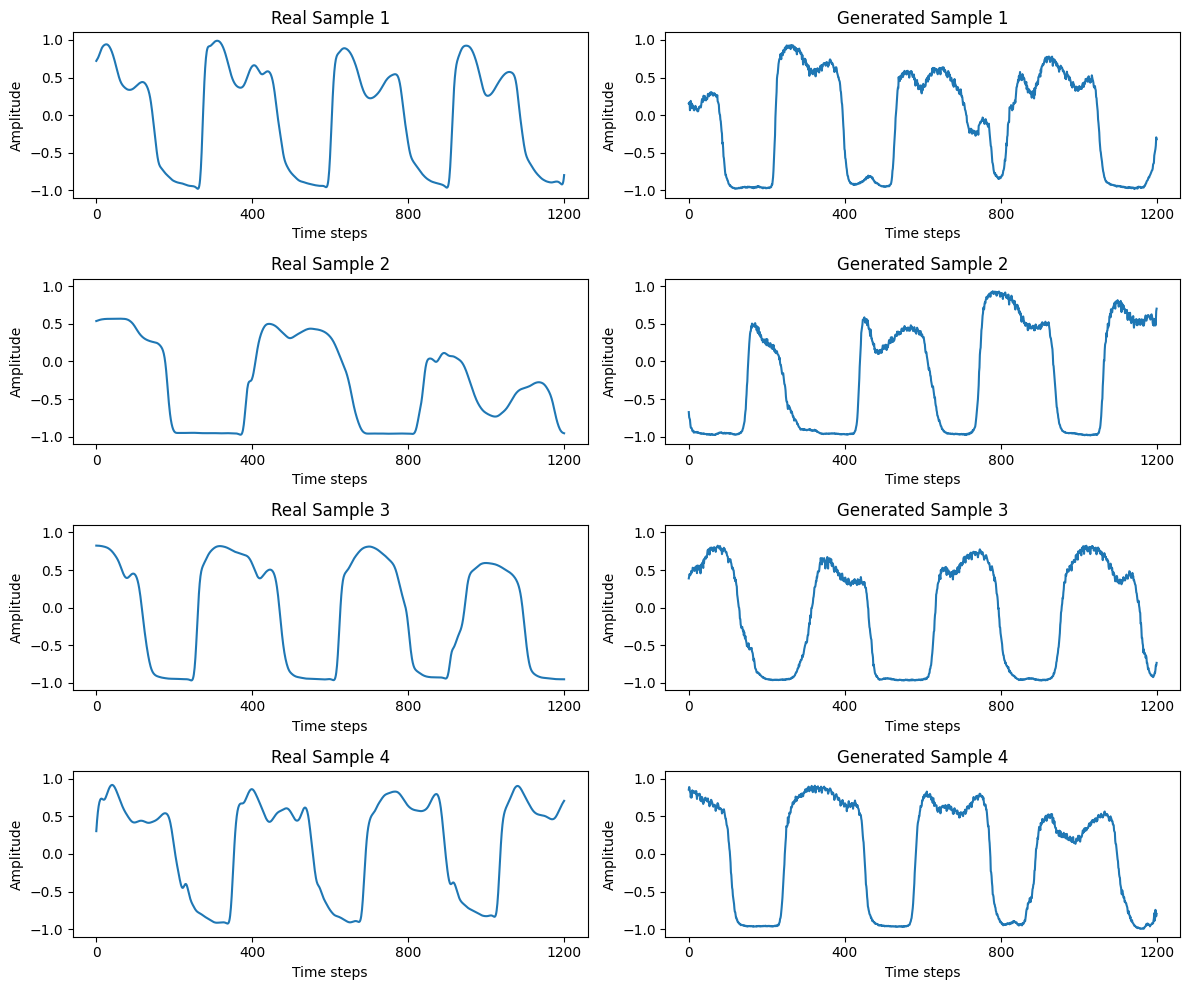

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt




# Parameters
NOISE_DIM = 64
num_samples = 4  # Match the number of samples in your image

# Define generator (same as in your training code)
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),
        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# Load real data
data_path = "/content/drive/MyDrive/hunt_right/hunt_all_right.npz"
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1  # Normalize to [-1, 1]
real_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

# Load generator
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/hunt_right/saved_models_hunt_right/generator_epoch_100.weights.h5')

# Generate samples
fixed_noise = tf.random.normal([num_samples, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False).numpy()

# Plotting
plt.figure(figsize=(12, 10))

for i in range(num_samples):
    # Real Sample
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.plot(real_samples[i, :])
    plt.title(f'Real Sample {i+1}')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.ylim(-1.1, 1.1)
    plt.xticks([0, 400, 800, 1200])

    # Generated Sample
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.plot(generated_samples[i, :, 0])
    plt.title(f'Generated Sample {i+1}')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.ylim(-1.1, 1.1)
    plt.xticks([0, 400, 800, 1200])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


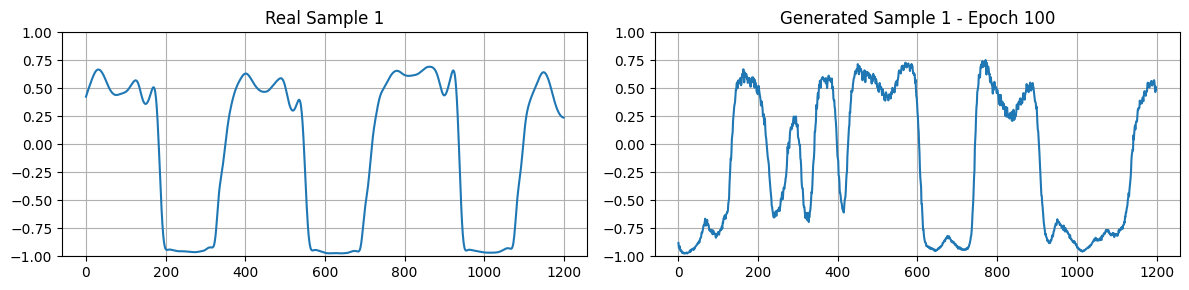

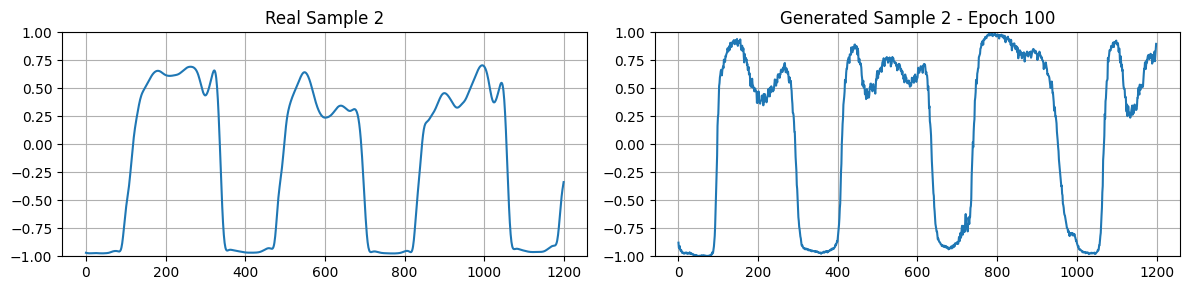

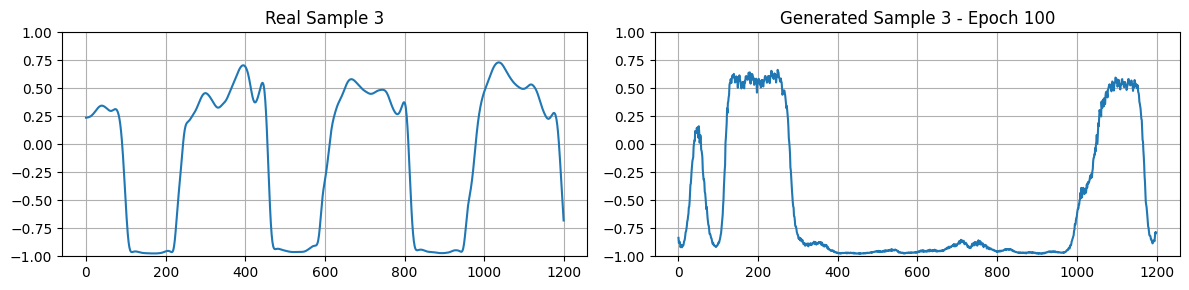

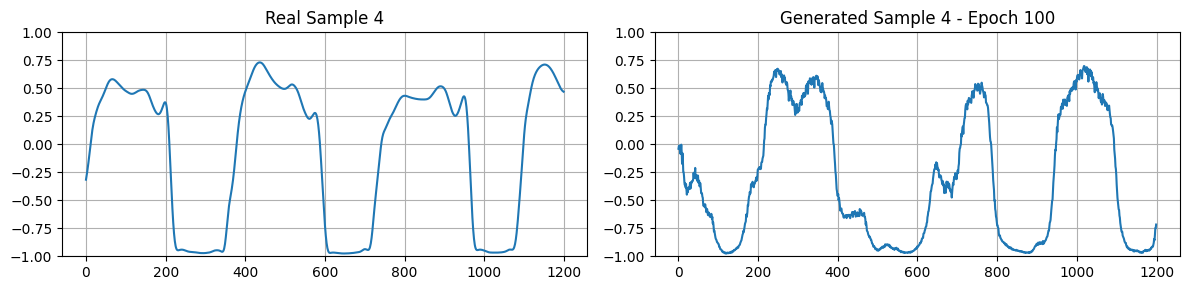

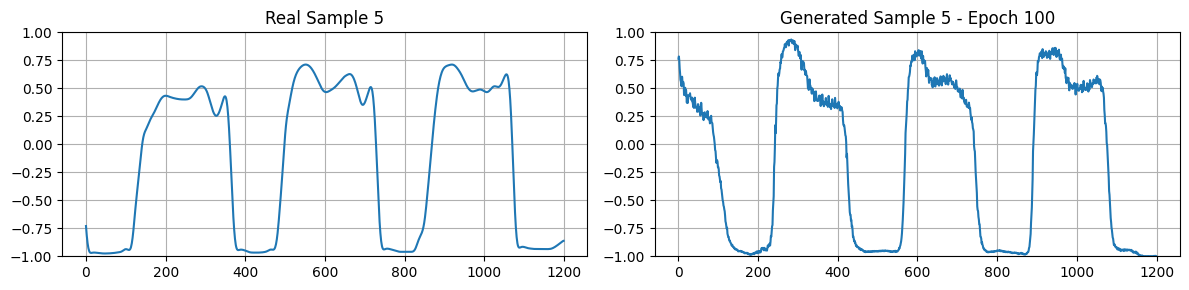

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# === Parameters ===
NOISE_DIM = 64
data_path = "/content/drive/MyDrive/hunt_right/hunt_all_right.npz"

# === Load data for comparison ===
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
data = data.astype(np.float32)

# === Redefine the generator architecture ===
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),

        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# === Load generator weights from epoch 100 ===
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/hunt_right/saved_models_hunt_right/generator_epoch_100.weights.h5')

# === Generate fixed noise and generate samples ===
fixed_noise = tf.random.normal([5, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False)

# === Plot real vs generated ===
for i in range(5):
    plt.figure(figsize=(12, 3))

    # Real sample
    plt.subplot(1, 2, 1)
    plt.plot(data[i, :, 0])
    plt.title(f"Real Sample {i+1}")
    plt.ylim(-1, 1)
    plt.grid(True)

    # Generated sample
    plt.subplot(1, 2, 2)
    plt.plot(generated_samples[i, :, 0])
    plt.title(f"Generated Sample {i+1} - Epoch 100")
    plt.ylim(-1, 1)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📏 MMD Score: 0.020005114035923127
🔄 Average DTW Distance: 11.922382575222127
🔁 Average Cross-Correlation: -0.10362340785664698


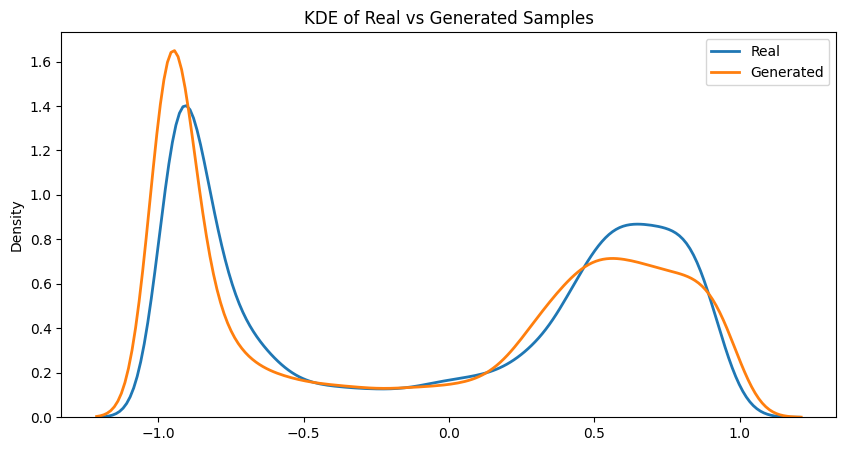

In [ ]:
!pip install dtaidistance

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from dtaidistance import dtw
import seaborn as sns

# --- Paramètres ---
NOISE_DIM = 64
num_samples = 100  # Nombre d'échantillons à comparer

# --- Chargement des données réelles ---
data_path = "/content/drive/MyDrive/hunt_right/hunt_all_right.npz"
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
real_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

# --- Générateur ---
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),
        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# --- Chargement du générateur préentraîné ---
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/hunt_right/saved_models_hunt_right/generator_epoch_190.weights.h5')

# --- Génération des échantillons ---
fixed_noise = tf.random.normal([num_samples, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False).numpy()

# --- MMD ---
def compute_mmd(x, y, gamma=1.0):
    xx = rbf_kernel(x, x, gamma=gamma)
    yy = rbf_kernel(y, y, gamma=gamma)
    xy = rbf_kernel(x, y, gamma=gamma)
    return np.mean(xx) + np.mean(yy) - 2 * np.mean(xy)

real_flat = real_samples.reshape(real_samples.shape[0], -1)
fake_flat = generated_samples.reshape(generated_samples.shape[0], -1)

mmd_score = compute_mmd(real_flat, fake_flat, gamma=0.1)
print("📏 MMD Score:", mmd_score)

# --- DTW ---
def compute_average_dtw(real_samples, generated_samples):
    dtw_distances = []
    for r, g in zip(real_samples, generated_samples):
        dist = dtw.distance(r.flatten(), g.flatten())
        dtw_distances.append(dist)
    return np.mean(dtw_distances)

dtw_score = compute_average_dtw(real_samples, generated_samples)
print("🔄 Average DTW Distance:", dtw_score)

# --- Cross-Correlation ---
def cross_correlation(a, b):
    a = (a - np.mean(a)) / (np.std(a) + 1e-8)
    b = (b - np.mean(b)) / (np.std(b) + 1e-8)
    return np.correlate(a, b, mode='valid')[0] / len(a)

ccs = [cross_correlation(r.flatten(), g.flatten()) for r, g in zip(real_samples, generated_samples)]
print("🔁 Average Cross-Correlation:", np.mean(ccs))

# --- Visualisation KDE ---
plt.figure(figsize=(10, 5))
sns.kdeplot(real_samples.reshape(-1), label="Real", linewidth=2)
sns.kdeplot(generated_samples.reshape(-1), label="Generated", linewidth=2)
plt.legend()
plt.title("KDE of Real vs Generated Samples")
plt.show()